In [52]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [91]:
vehiculo = 'DA04'

In [92]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
elif vehiculo == 'DA04':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_04'
contenido = os.listdir(path_log)
len(contenido)

271

In [93]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [94]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [95]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

11

In [96]:
contenido_filtrado

['2026-02-19 22-36-39.tlog',
 '2026-02-19 22-52-03.tlog',
 '2026-02-19 23-26-36.tlog',
 '2026-02-19 23-34-19.tlog',
 '2026-02-20 00-11-09.tlog',
 '2026-02-21 00-48-18.tlog',
 '2026-02-21 02-15-17.tlog',
 '2026-02-21 03-07-29.tlog',
 '2026-02-21 03-25-02.tlog',
 '2026-02-21 03-46-24.tlog',
 '2026-02-21 04-16-43.tlog']

In [97]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        print(name)
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [98]:
lineas, names = leer_logs(contenido_filtrado)
lineas

2026-02-19 22-36-39.tlog
2026-02-19 22-52-03.tlog
2026-02-19 23-26-36.tlog
2026-02-19 23-34-19.tlog
2026-02-20 00-11-09.tlog
2026-02-21 00-48-18.tlog
2026-02-21 02-15-17.tlog
2026-02-21 03-07-29.tlog
2026-02-21 03-25-02.tlog
2026-02-21 03-46-24.tlog
2026-02-21 04-16-43.tlog


[<LINESTRING (-63.602 -17.223, -63.602 -17.223, -63.602 -17.223, -63.602 -17....>,
 <LINESTRING (-63.602 -17.223, -63.602 -17.223, -63.602 -17.223, -63.602 -17....>,
 <LINESTRING (-63.598 -17.22, -63.598 -17.22, -63.598 -17.22, -63.598 -17.22,...>,
 <LINESTRING (0 0, -63.598 -17.22, -63.598 -17.22, -63.598 -17.22, -63.598 -1...>,
 <LINESTRING (-63.588 -17.22, -63.588 -17.22, -63.588 -17.22, -63.588 -17.22,...>,
 <LINESTRING (-63.196 -17.383, -63.196 -17.383, -63.196 -17.383, -63.196 -17....>,
 <LINESTRING (-63.168 -17.335, -63.168 -17.335, -63.168 -17.335, -63.168 -17....>,
 <LINESTRING (-63.164 -17.332, -63.164 -17.332, -63.164 -17.332, -63.164 -17....>,
 <LINESTRING (-63.164 -17.332, -63.164 -17.332, -63.164 -17.332, -63.164 -17....>,
 <LINESTRING (-63.168 -17.332, -63.168 -17.332, -63.168 -17.332, -63.168 -17....>,
 <LINESTRING (-63.164 -17.339, -63.164 -17.339, -63.164 -17.339, -63.164 -17....>]

In [99]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2026-02-19 22-36-39.tlog,"LINESTRING (-63.60241 -17.22284, -63.60241 -17..."
1,2026-02-19 22-52-03.tlog,"LINESTRING (-63.60236 -17.22285, -63.60236 -17..."
2,2026-02-19 23-26-36.tlog,"LINESTRING (-63.59820 -17.22047, -63.59820 -17..."


In [100]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [101]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [102]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [103]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2026-02-19 22-36-39.tlog,"LINESTRING (-63.60241 -17.22284, -63.60241 -17...",3586,DA04
1,2026-02-19 22-52-03.tlog,"LINESTRING (-63.60236 -17.22285, -63.60236 -17...",1773,DA04
2,2026-02-19 23-26-36.tlog,"LINESTRING (-63.59820 -17.22047, -63.59820 -17...",3957,DA04


<Axes: >

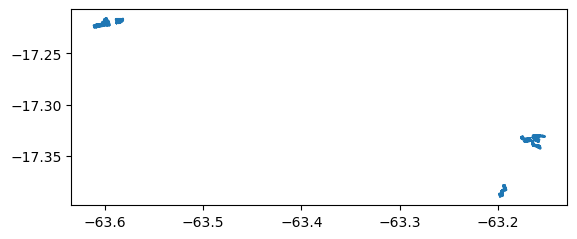

In [104]:
gdf_lines.plot()

In [105]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

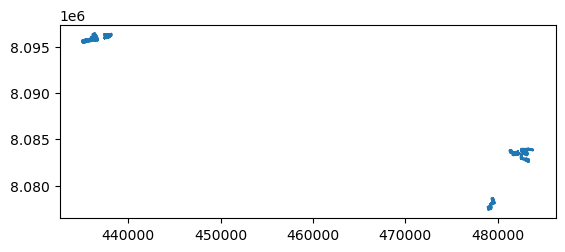

In [106]:
gdf_lines_utm.plot()

In [107]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [108]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2026-02-19 22-36-39.tlog,"LINESTRING (435953.268 8095693.660, 435953.300...",3586,DA04,0
1,2026-02-19 22-52-03.tlog,"LINESTRING (435958.515 8095692.116, 435958.526...",1773,DA04,0
2,2026-02-19 23-26-36.tlog,"LINESTRING (436399.477 8095956.980, 436399.477...",3957,DA04,0
3,2026-02-19 23-34-19.tlog,"LINESTRING (436401.580 8095957.584, 436401.591...",1187,DA04,0
4,2026-02-20 00-11-09.tlog,"LINESTRING (437464.697 8095962.126, 437464.708...",3921,DA04,0
5,2026-02-21 00-48-18.tlog,"LINESTRING (479181.363 8078015.511, 479181.373...",3807,DA04,0
6,2026-02-21 02-15-17.tlog,"LINESTRING (482138.964 8083365.392, 482138.953...",1994,DA04,0
7,2026-02-21 03-07-29.tlog,"LINESTRING (482533.543 8083739.195, 482533.554...",4042,DA04,0
8,2026-02-21 03-25-02.tlog,"LINESTRING (482532.310 8083739.559, 482532.289...",2018,DA04,0
9,2026-02-21 03-46-24.tlog,"LINESTRING (482181.649 8083665.732, 482181.639...",1614,DA04,0


In [109]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)